In [1]:
import numpy as np
import os
import util as u
import MRI_layers_MK1 as mri
import matplotlib.pyplot as plt
import pickle


#import contour #class 

import argparse
#we'll use the above for commandline arguments (scanfiles, maskfile)

#import contour class
from contour import *

<ipython-input-17-55eade15dc74>:12: UserWarning: No contour levels were found within the data range.
  plt.contour(masks[2], [0], colors='red')


19

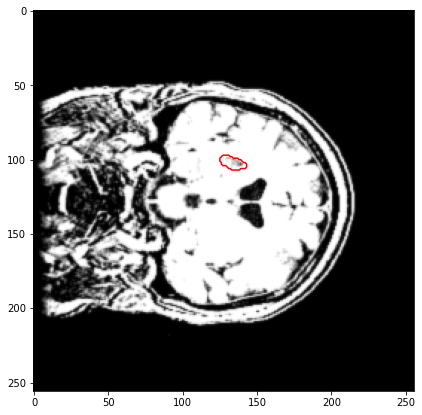

In [17]:
base = "C:\\Users\\david\\Desktop\\Final_Pickles"
fpaths = [os.path.join(base,p) for p in os.listdir(base)]

ind = 1

s, m = mri.load_data(fpaths[ind])

scans, masks = mri.preprocess(s, m, normalize=True, contrast_factor = 2, blur_rad=0.6)

plt.figure(figsize=(7,7))
plt.imshow(scans[2],cmap='gray')
plt.contour(masks[2], [0], colors='red')
len(scans)

<ipython-input-19-2ce1c07a9a54>:16: UserWarning: No contour levels were found within the data range.
  plt.contour(masks[0], [0], colors='red')


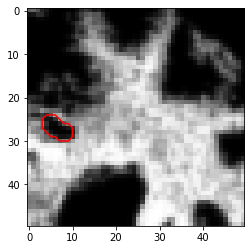

In [19]:
#load data using functions in mri layers module (rename that to mri)
base = "C:\\Users\\david\\Desktop\\Final_Pickles"
fpaths = [os.path.join(base,p) for p in os.listdir(base)]

s, m = mri.load_data(fpaths[ind])

#contrasting works better when you first isolate the part of the image you want 
#add this in the preprocessing pipeline 
_scans = [scan[75:125, 130:180] for scan in s]
_masks = [mask[75:125, 130:180] for mask in m]

#scans, masks = mri.preprocess(_scans, _masks, normalize=True, contrast_factor = 1, blur_rad=0)
scans, masks = mri.preprocess(_scans, _masks, normalize=True, contrast_factor = 12, blur_rad=0.6)

plt.imshow(scans[0], cmap = 'gray')
plt.contour(masks[0], [0], colors='red')


#ind 0: 120:190, 130:210
#ind 1 : 50:150, 80:180
#ind 2: 130:170, 110:150
#ind 3: 100:150, 75:125
#ind 4 75:125, 130:180

#index 0: 85:165, 130:210
#index 1: 120:190, 130:210
#index 2: 115:185, 100:180
#index 3: 100:190, 90:190
#index 8: 50:150, 80:180
#index 9: 140:210, 140:210

In [4]:
len(masks)

19

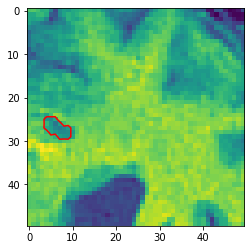

In [5]:
ref = masks[0]

#initial convergence using segmentation
def f0(surface, image):
    F1 = u.mean_curvature(surface)
    F2 = (image-1.0)**2 - (image - 0)**2
    return 0.001*F1 + 0.11*F2

#random circle shape 
p0 = u.parabloid(ref.shape, xrad=0.5, yrad=0.5)
c0 = contour(p0, f0)
c0.iterate(ref, numiters=5500, dt = 0.001)

#check to see that it worked
plt.contour(c0.s, [0], colors='red')
#plt.contour(ref, [0], colors='magenta')
plt.imshow(scans[0])

In [6]:
#now setup some things for the sequential component...

#keep track of contours 
contours = []
contours.append(c0)

#intensities (these are not inherent to dataset, function of preprocess contrast)
interior_intensities = []
exterior_intensities = []

#areas 
area = lambda arr: len(contour.positive_indeces(arr, geq=False))
areas = []
areas.append(area(c0.s))

#supervised:
_areas = [area(mask) for mask in masks]


In [7]:
#numscans = len(scans)-1
numscans = min(15, len(scans))

import time 

start = time.time()

for i in range(numscans):
    index = len(contours)
    
    #images and contours we need 
    prev_c = contours[index-1]
    prev_scan = scans[index-1]
    scan = scans[index]
    
    #dynamically define a functional to instantiate contour object with 
    #intensity:
    i_in, i_out = prev_c.intensity(prev_scan, steps=3)
    
    #append 
    interior_intensities.append(i_in)
    exterior_intensities.append(i_out)

    #average vals 
    i_in_avg = np.mean(interior_intensities)
    i_out_avg = np.mean(exterior_intensities)
    
    #area: 
    if index < 4:
        #supervised
        a = _areas[index]
    else:
        increments = np.linspace(0,len(areas)-1, len(areas))
        area_estimator = np.poly1d(np.polyfit(increments, areas, 0.5))
        a = area_estimator(index)
     
    #define functional on a per iteration basis 
    def f(surface, image):
        #arclength
        F1 = u.mean_curvature(surface)
        
        #segmentation
        F2 = (image-i_in_avg)**2 - (image - i_out_avg)**2

        #area 
        F3 = 2*(area(surface) - 1.0*a)
    
        return 0.0003*F1 + 0.06*F2 #0.0003*F1 + 0.06*F2 + 0.02*F3
    
    
    #instantiate new contour object 
    simplified = u.surf2simple(prev_c.s)
    c = contour(simplified, f)
    
    #solve
    c.iterate(scan, numiters=4500, dt=0.00075)
    
    #append
    contours.append(c)
    areas.append(area(c.s))
    
    print(index)

stop = time.time()

print(stop-start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
57.97721791267395


<ipython-input-8-af463798d3f1>:6: UserWarning: No contour levels were found within the data range.
  c1 = plt.contour(masks[index], [0], colors='magenta', linewidths=2.5)


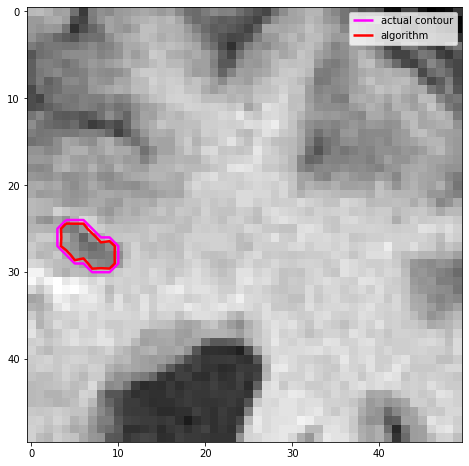

In [8]:
index=0

plt.figure(figsize=(8,8))

plt.imshow(scans[index], cmap='gray')
c1 = plt.contour(masks[index], [0], colors='magenta', linewidths=2.5)
c2 = plt.contour(contours[index].s, [0], colors='red', linewidths=2.5)

h1,_ = c1.legend_elements()
h2,_ = c2.legend_elements()

plt.legend([h1[0], h2[0]], ['actual contour', 'algorithm'])

In [9]:
#kaitlyn's stuff 
def diceCoef(correct_mask, algo_mask):
    #Calculate how many points intersect
    #Goes in numerator of dice coefficient
    correct_mask_bool = np.asarray(correct_mask).astype(np.bool)
    algo_mask_bool = np.asarray(algo_mask).astype(np.bool)
    
    mask_intersect = np.logical_and(correct_mask_bool, algo_mask_bool)
    total_intersect = mask_intersect.sum()
    
    #Calculate number of points in each mask
    #Goes in denominator of dice coefficent
    points_correct = correct_mask_bool.sum()
    points_algo = algo_mask_bool.sum()
    
    dice_denom_sum = points_correct + points_algo
    
    #Compute dice's coefficient
    diceCoefficient = 2.*total_intersect/dice_denom_sum
    
    #print(diceCoefficient)
    if diceCoefficient == 0: 
        return 0
    else: 
        return diceCoefficient

In [10]:
dicescores = []
for i,c in enumerate(contours):
    test_contour = c.s
    test_mask = contour.converged2mask(test_contour)
    
    #compute score
    score = diceCoef(masks[i], test_mask)
    dicescores.append(score)

Text(0.5, 1.0, 'Dice Score vs Layer')

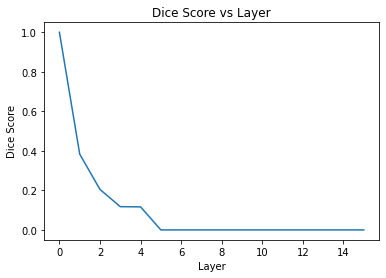

In [11]:
plt.plot(dicescores)
plt.xlabel('Layer')
plt.ylabel('Dice Score')
plt.title('Dice Score vs Layer')

<ipython-input-12-462a4348c579>:8: UserWarning: No contour levels were found within the data range.
  c1 = axs[i,j].contour(masks[index], [0], colors='magenta', linewidths=2.5)
<ipython-input-12-462a4348c579>:9: UserWarning: No contour levels were found within the data range.
  c2 = axs[i,j].contour(contours[index].s, [0], colors='red', linewidths=2.5)


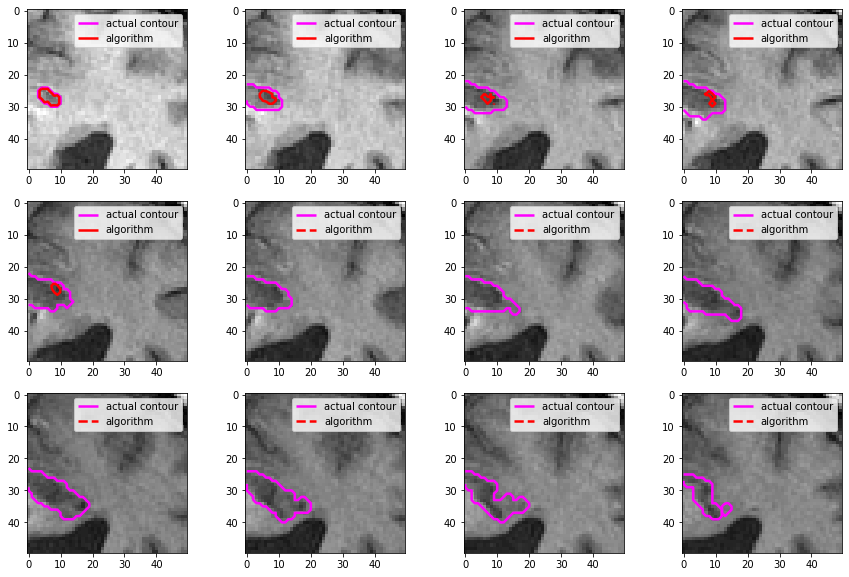

In [12]:
#lets show some subplots for the first 9 iterations here
fig, axs = plt.subplots(3, 4, figsize=(15,10))

index = 0
for i in range(3):
    for j in range(4):
        axs[i,j].imshow(scans[index], cmap='gray')
        c1 = axs[i,j].contour(masks[index], [0], colors='magenta', linewidths=2.5)
        c2 = axs[i,j].contour(contours[index].s, [0], colors='red', linewidths=2.5)

        h1,_ = c1.legend_elements()
        h2,_ = c2.legend_elements()

        axs[i,j].legend([h1[0], h2[0]], ['actual contour', 'algorithm'])
        
        index+=1


In [ ]:
fig.savefig('int_and_arc.png')

In [13]:
dicescores

[1.0,
 0.3835616438356164,
 0.20454545454545456,
 0.11764705882352941,
 0.11650485436893204,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [14]:
sum(dicescores)/len(dicescores)

0.11389118822334578

In [ ]:
ind_large = np.where(masks == max([area(mask) for mask in masks]))

print(ind_large)

In [ ]:
#Start of two-way attempt

In [ ]:
#areas 
area = lambda arr: len(contour.positive_indeces(arr, geq=False))
areas = []

#supervised:
_areas = [area(mask) for mask in masks]
ind_large = _areas.index(max(_areas))

ref = masks[ind_large]

#initial convergence using segmentation
def f0(surface, image):
    F1 = u.mean_curvature(surface)
    F2 = (image-1.0)**2 - (image - 0)**2
    return 0.001*F1 + 0.11*F2

#random circle shape 
p0 = u.parabloid(ref.shape, xrad=0.5, yrad=0.5)
c0 = contour(p0, f0)
c0.iterate(ref, numiters=5500, dt = 0.001)

#check to see that it worked
plt.contour(c0.s, [0], colors='red')
#plt.contour(ref, [0], colors='magenta')
plt.imshow(scans[ind_large])

In [ ]:
#now setup some things for the sequential component...

#keep track of contours 
l_contours = []
l_contours.append(c0)

r_contours = []
r_contours.append(c0)
#intensities (these are not inherent to dataset, function of preprocess contrast)
l_interior_intensities = []
l_exterior_intensities = []

r_interior_intensities = []
r_exterior_intensities = []
#areas 

#l_areas = []
#r_areas = []

areas = np.empty((len(masks), 1))
areas[ind_large] = area(c0.s)

#l_areas.append(area(c0.s))
#r_areas.append(area(c0.s))

In [ ]:
left = ind_large -1
right = ind_large +1
left_flag = False
right_flag = False


import time 

start = time.time()

count = 0

while (not left_flag or not right_flag) and (count < 7):
    if not left_flag:
        #images and contours we need 
        l_prev_c = l_contours[count]
        l_prev_scan = scans[left +1]
        l_scan = scans[left]
        
        l_i_in, l_i_out = l_prev_c.intensity(l_prev_scan, steps=3)
        
        l_interior_intensities.append(l_i_in)
        l_exterior_intensities.append(l_i_out)
        
        l_i_in_avg = np.mean(l_interior_intensities)
        l_i_out_avg = np.mean(l_exterior_intensities)
        
        if count < 2:
            #supervised
            l_a = _areas[left]
        else:
            increments = np.linspace(left+1, right-1, right-left-1)
            area_estimator = np.poly1d(np.polyfit(increments, areas[left+1:right].flatten(), 0.5))
            l_a = area_estimator(left)

        #define functional on a per iteration basis 
        def l_f(surface, image):
            #arclength
            F1 = u.mean_curvature(surface)

            #segmentation
            F2 = (image-l_i_in_avg)**2 - (image - l_i_out_avg)**2

            #area 
            F3 = 2*(area(surface) - l_a)

            return 0.0003*F1 + 0.06*F2 + 0.02*F3

            #left
        #instantiate new contour object 
        l_simplified = u.surf2simple(l_prev_c.s)
        l_c = contour(l_simplified, l_f)

        #solve
        l_c.iterate(l_scan, numiters=4500, dt=0.00075)

        #append
        l_contours.append(l_c)
        areas[left] = area(l_c.s)
        #l_areas.append(area(l_c.s))

        
    if not right_flag:
        #images and contours we need 
        r_prev_c = r_contours[count]
        r_prev_scan = scans[right-1]
        r_scan = scans[right]
    
        #dynamically define a functional to instantiate contour object with 
        #intensity:


        r_i_in, r_i_out = r_prev_c.intensity(r_prev_scan, steps=3)

        #append 


        r_interior_intensities.append(r_i_in)
        r_exterior_intensities.append(r_i_out)

        #average vals 


        r_i_in_avg = np.mean(r_interior_intensities)
        r_i_out_avg = np.mean(r_exterior_intensities)

        #area: 
        if count < 2:
            r_a = _areas[right]
        else:
            increments = np.linspace(left+1, right-1, right-left-1)
            area_estimator = np.poly1d(np.polyfit(increments, areas[left+1:right].flatten(), 0.5))
            r_a = area_estimator(right)

        #define functional on a per iteration basis 
       
        def r_f(surface, image):
            #arclength
            F1 = u.mean_curvature(surface)

            #segmentation
            F2 = (image-r_i_in_avg)**2 - (image - r_i_out_avg)**2

            #area 
            F3 = 2*(area(surface) - r_a)

            return 0.0003*F1 + 0.06*F2 + 0.02*F3


        #right
        #instantiate new contour object 
        r_simplified = u.surf2simple(r_prev_c.s)
        r_c = contour(r_simplified, r_f)

        #solve
        r_c.iterate(r_scan, numiters=4500, dt=0.00075)

        #append
        r_contours.append(r_c)
        areas[right] = area(r_c.s)
        #r_areas.append(area(r_c.s))
   

    print(f'left = {left}, right = {right}, count = {count}')
    count += 1
    
    
    if left == 0:
        left_flag = True
    if right == len(masks)-1:
        right_flag = True
    if not left_flag:
        left -= 1
    if  not right_flag:
        right += 1    
    


stop = time.time()

print(stop-start)

In [ ]:
l_prev_scan.shape

In [ ]:
contours = l_contours[::-1][:-1]
contours = np.concatenate((contours, r_contours))
contours

In [ ]:
dicescores = []
for i,c in enumerate(contours):
    test_contour = c.s
    test_mask = contour.converged2mask(test_contour)
    
    #compute score
    score = diceCoef(masks[i], test_mask)
    dicescores.append(score)

In [ ]:
plt.plot(dicescores)

In [ ]:
#lets show some subplots for the first 9 iterations here
fig, axs = plt.subplots(3, 5, figsize=(15,10))

index = 0
for i in range(3):
    for j in range(5):
        axs[i,j].imshow(scans[index], cmap='gray')
        c1 = axs[i,j].contour(masks[index], [0], colors='magenta', linewidths=2.5)
        c2 = axs[i,j].contour(contours[index].s, [0], colors='red', linewidths=2.5)

        h1,_ = c1.legend_elements()
        h2,_ = c2.legend_elements()

        axs[i,j].legend([h1[0], h2[0]], ['actual contour', 'algorithm'])
        
        index+=1


In [ ]:
sum(dicescores)/len(dicescores)

In [ ]:
plt.figure(figsize = (7,7))
plt.imshow(scans[7], cmap='gray')
plt.contour(l_contours[1].s,[0], colors = 'red',linewidths=2.5)
plt.contour(masks[7], [0], colors = 'magenta',linewidths=2.5)

In [ ]:
plt.figure(figsize = (7,7))
plt.imshow(scans[9], cmap='gray')
plt.contour(r_contours[1].s,[0], colors = 'red',linewidths=2.5)
plt.contour(masks[9], [0], colors = 'magenta',linewidths=2.5)

In [ ]:
dicescores